# Predicting BitCoin Volume

## Goals:

- Investigate drivers of volume in BitCoin Market Data from January 2018 to December 2022.

- Construct a ML time-series model that accurately predicts volume of Bitcoin.

# Import

In [96]:
import warnings
warnings.filterwarnings("ignore")


import requests

import pandas as pd
import numpy as np
from scipy import stats
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

from datetime import datetime

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit 


import wrangle as w
import explore as e
import model as m

# Acquire

- Data acquired from messari.io


- It contained 1768 rows and 5 columns before cleaning


- Each row represents one day from 01/01/2018 to 12/12/2022


- Each column represents a feature that describes BitCoin

In [2]:
# Acquiring and cleaning data
btc = w.get_crypto_price('btc', '2018-01-01', '2022-12-12')

btc = w.clean_data(btc)

In [103]:
btc.head(3)

,btc_open,btc_high,btc_low,btc_close,btc_volume
date,,,,,
2018-01-01,13715.65,13818.55,12750.00,13380.00,8609.915844
2018-01-02,13382.16,15473.49,12890.02,14675.11,20078.092111
2018-01-03,14690.00,15307.56,14150.00,14919.51,15905.667639


In [104]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2018-01-01 to 2022-12-31
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   btc_open    1825 non-null   float64
 1   btc_high    1825 non-null   float64
 2   btc_low     1825 non-null   float64
 3   btc_close   1825 non-null   float64
 4   btc_volume  1825 non-null   float64
dtypes: float64(5)
memory usage: 150.1 KB


# Prepare

- Check for nulls (nulls were found and filled with nearest date)


- Checked for missing dates, filled 40 missing dates with data from the nearest data.


- Extended the length of data from 12-12-2022 to 12-31-2022, then filled data with nearest dates for modeling purposes.


- Renamed columns for readability


- Split data into train, validate, and test sets


- All observations were significant, none were removed


- We have 1825 rows after cleaning and filling.

| Feature | Definition |
| :- | :- |
| btc_open | Decimal value, opening price of BitCoin for the day. |
| btc_close | Decimal value, closing price of BitCoin for the day. |
| btc_high | Decimal value, highest price of BitCoin for the day. |
| btc_low | Decimal value, lowest price of BitCoin for the day. |
| btc_volume | Decimal value, number of shares traded in BitCoin for the day. |

In [3]:
# split into train, validate, test by year
train = btc[:'2020']
validate = btc['2021']
test = btc['2022']

# Explore


- Only exploring the train data.

## Questions:

- Does volume have seasonality over time?


- Do opening price and volume have a relationship?


- Do closing price and volume have a relationship?


- Do highest price and volume have a relationship?


- Do lowest price and volume have a relationship?

# Looking into seasonality..

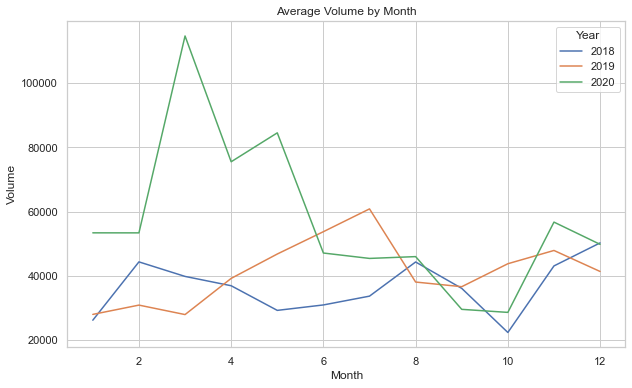

In [97]:
# get plot of Average Volume of BitCoin per month
e.get_avg_vol_monthly()

- Monthly averages seem to share very weak seasonality that only appears in around September-November.

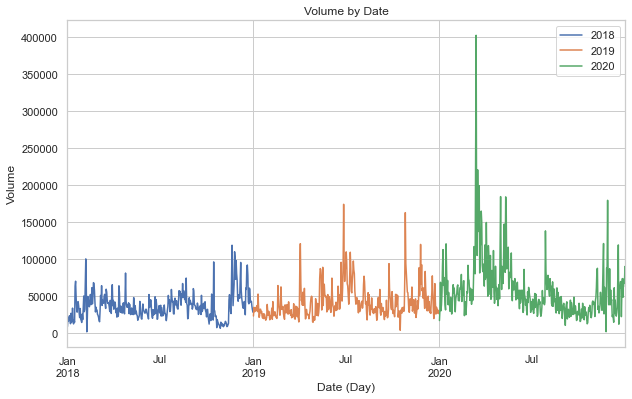

In [98]:
# get plot of Volume for each day
e.get_vol_by_date()

- Daily values appear to share little to no seasonality over the span of 3 years.

## Do open, close, highest or lowest price share a relationship with volume?

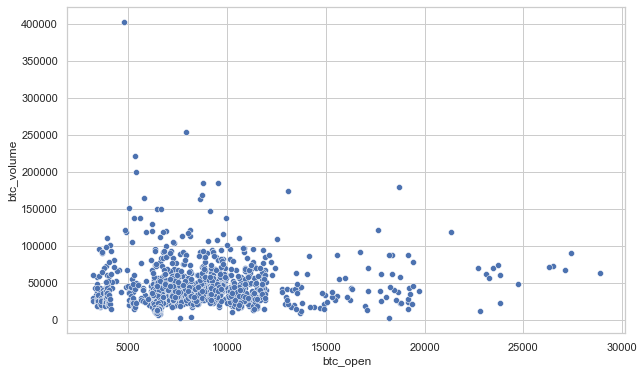

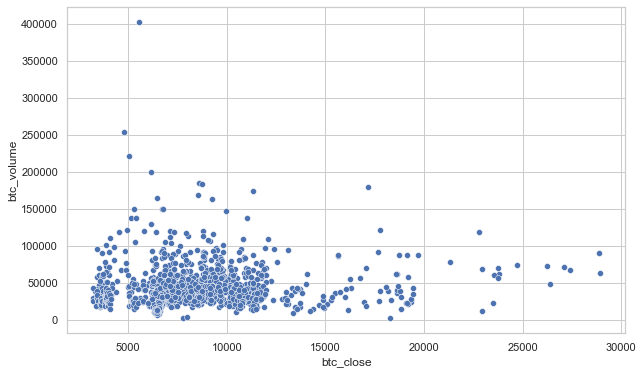

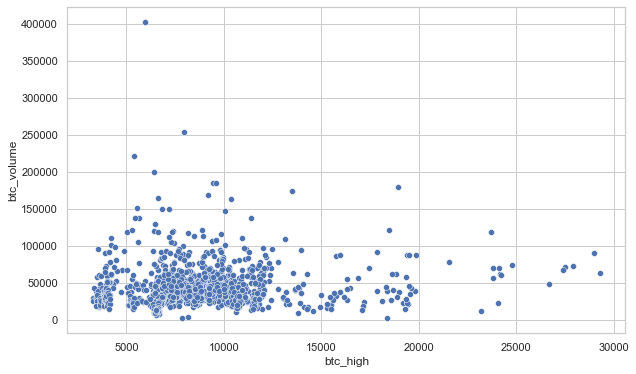

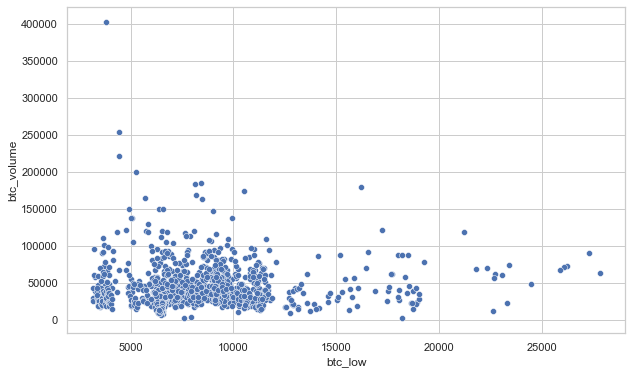

In [99]:
e.plot_price_vol()

- There appears

# Modeling ig

In [ ]:
col = 'btc_volume'

In [79]:
def update_eval_df(model_type, eval_df, col, validate, yhat_df):
    rmse = m.evaluate(col, validate, yhat_df)
    d = {'model_type': [model_type], 'target_var': [col], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    eval_df=eval_df.append(d, ignore_index = True)
    
    return eval_df

In [80]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# Initialize volume, yhat_df, and period for modeling
# setting btc_volume to variable to use in function arguments
volume = 0

yhat_df = pd.DataFrame({'btc_volume': [volume]}, 
                       index = validate.index)

period = 0

col = 'btc_volume'

## Last Observed

In [81]:
# get last_observed model and update eval_df
volume, yhat_df = m.get_btc_last_observed(train, validate, volume, yhat_df)

eval_df = update_eval_df('last_observed', eval_df, col, validate, yhat_df)

eval_df

,model_type,target_var,rmse
0,last_observed,btc_volume,36067.0


btc_volume -- RMSE: 36067


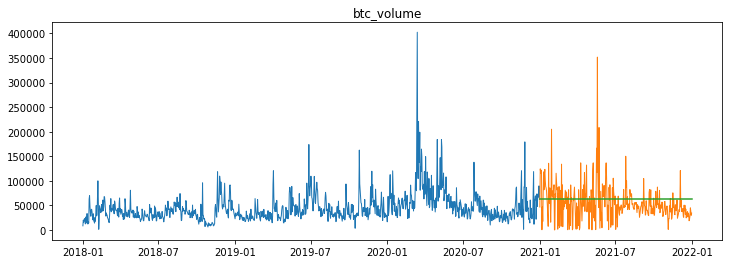

In [82]:
m.plot_and_eval(col, train, validate, yhat_df)

## Simple Average

In [83]:
volume, yhat_df = m.get_btc_simple_average(train, validate, volume, yhat_df)

eval_df = update_eval_df('simple_average', eval_df, col, validate, yhat_df)

eval_df

,model_type,target_var,rmse
0,last_observed,btc_volume,36067.0
1,simple_average,btc_volume,36780.0


btc_volume -- RMSE: 36780


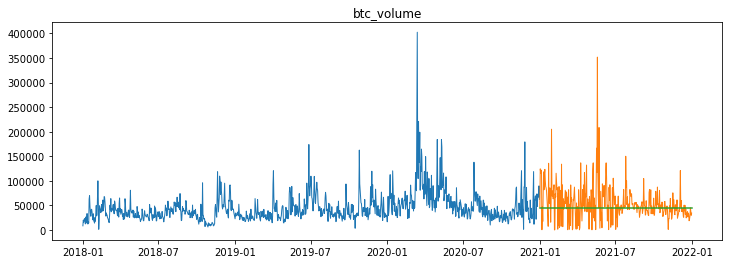

In [84]:
m.plot_and_eval(col, train, validate, yhat_df)

# Moving Average

### 30 Day Period

In [85]:
volume, yhat_df = m.get_btc_30d_average(train, validate, volume, yhat_df)

eval_df = update_eval_df('30d_moving_average', eval_df, col, validate, yhat_df)

eval_df

,model_type,target_var,rmse
0,last_observed,btc_volume,36067.0
1,simple_average,btc_volume,36780.0
2,30d_moving_average,btc_volume,35674.0


btc_volume -- RMSE: 35674


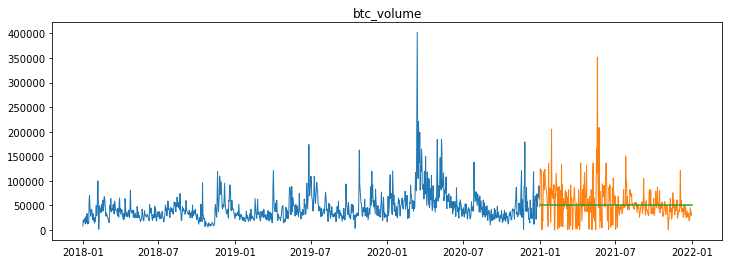

In [86]:
m.plot_and_eval(col, train, validate, yhat_df)

### 7 Day Period

In [87]:
volume, yhat_df = m.get_btc_7d_average(train, validate, volume, yhat_df)

eval_df = update_eval_df('7d_moving_average', eval_df, col, validate, yhat_df)

eval_df

,model_type,target_var,rmse
0,last_observed,btc_volume,36067.0
1,simple_average,btc_volume,36780.0
2,30d_moving_average,btc_volume,35674.0
3,7d_moving_average,btc_volume,38030.0


### 14 Day Period

In [88]:
volume, yhat_df = m.get_btc_14d_average(train, validate, volume, yhat_df)

eval_df = update_eval_df('14d_moving_average', eval_df, col, validate, yhat_df)

eval_df

,model_type,target_var,rmse
0,last_observed,btc_volume,36067.0
1,simple_average,btc_volume,36780.0
2,30d_moving_average,btc_volume,35674.0
3,7d_moving_average,btc_volume,38030.0
4,14d_moving_average,btc_volume,35616.0


### 21 Day Period

In [89]:
volume, yhat_df = m.get_btc_21d_average(train, validate, volume, yhat_df)

eval_df = update_eval_df('21d_moving_average', eval_df, col, validate, yhat_df)

eval_df

,model_type,target_var,rmse
0,last_observed,btc_volume,36067.0
1,simple_average,btc_volume,36780.0
2,30d_moving_average,btc_volume,35674.0
3,7d_moving_average,btc_volume,38030.0
4,14d_moving_average,btc_volume,35616.0
5,21d_moving_average,btc_volume,35361.0


### 28 Day Period

In [90]:
volume, yhat_df = m.get_btc_28d_average(train, validate, volume, yhat_df)

eval_df = update_eval_df('28d_moving_average', eval_df, col, validate, yhat_df)

eval_df

,model_type,target_var,rmse
0,last_observed,btc_volume,36067.0
1,simple_average,btc_volume,36780.0
2,30d_moving_average,btc_volume,35674.0
3,7d_moving_average,btc_volume,38030.0
4,14d_moving_average,btc_volume,35616.0
5,21d_moving_average,btc_volume,35361.0
6,28d_moving_average,btc_volume,35676.0


### 120 Day Period

In [91]:
volume, yhat_df = m.get_btc_120d_average(train, validate, volume, yhat_df)

eval_df = update_eval_df('120d_moving_average', eval_df, col, validate, yhat_df)

eval_df

,model_type,target_var,rmse
0,last_observed,btc_volume,36067.0
1,simple_average,btc_volume,36780.0
2,30d_moving_average,btc_volume,35674.0
3,7d_moving_average,btc_volume,38030.0
4,14d_moving_average,btc_volume,35616.0
5,21d_moving_average,btc_volume,35361.0
6,28d_moving_average,btc_volume,35676.0
7,120d_moving_average,btc_volume,37989.0


# Previous Cycle

In [92]:
yhat_df = m.get_btc_previous_cycle(train, validate)

eval_df = update_eval_df('previous_cycle', eval_df, col, validate, yhat_df)

eval_df

,model_type,target_var,rmse
0,last_observed,btc_volume,36067.0
1,simple_average,btc_volume,36780.0
2,30d_moving_average,btc_volume,35674.0
3,7d_moving_average,btc_volume,38030.0
4,14d_moving_average,btc_volume,35616.0
5,21d_moving_average,btc_volume,35361.0
6,28d_moving_average,btc_volume,35676.0
7,120d_moving_average,btc_volume,37989.0
8,previous_cycle,btc_volume,54671.0


btc_volume -- RMSE: 54671


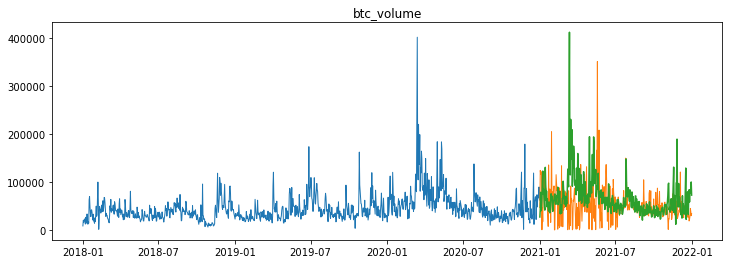

In [93]:
m.plot_and_eval(col, train, validate, yhat_df)

# Model on Test

In [94]:
volume, yhat_df = m.get_test_btc_21d_average(train, test, volume, yhat_df)

eval_df = update_eval_df('test_21d_moving_average', eval_df, col, test, yhat_df)

eval_df

,model_type,target_var,rmse
0,last_observed,btc_volume,36067.0
1,simple_average,btc_volume,36780.0
2,30d_moving_average,btc_volume,35674.0
3,7d_moving_average,btc_volume,38030.0
4,14d_moving_average,btc_volume,35616.0
5,21d_moving_average,btc_volume,35361.0
6,28d_moving_average,btc_volume,35676.0
7,120d_moving_average,btc_volume,37989.0
8,previous_cycle,btc_volume,54671.0
9,test_21d_moving_average,btc_volume,68477.0


btc_volume -- RMSE: 68477


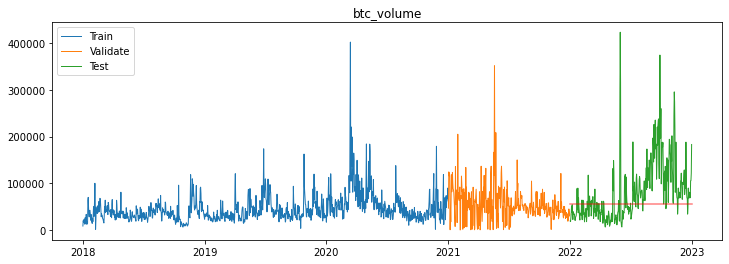

In [95]:
m.plot_and_eval_test(col, train, validate, test, yhat_df)